In [1]:
%matplotlib inline
from pathlib import Path
from cartopy import crs as ccrs
import matplotlib.pylab as plt
import matplotlib.gridspec as gridspec
from matplotlib.patches import Rectangle
import astropy.constants as astro
import xarray as xr
import netCDF4 as nc
import pandas as pd
import numpy as np
import scipy as sc
import os
import sys
from windrose import WindroseAxes
import matplotlib.cm as cm
from scipy import integrate
import seaborn as sns
import datetime

def savefig(filename, directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')
    else:
        plt.savefig(directory_path + filename, facecolor='white', bbox_inches='tight')
        
def save_netcdf(ds, name_file, directory_path):
    if not os.path.exists(directory_path):
        os.makedirs(directory_path)
        ds.to_netcdf(directory_path + name_file, mode='w')
    else:
        ds.to_netcdf(directory_path + name_file, mode='w')

from box_coordinates_and_paths import choose_region

In [2]:
def derivatives(new_grid, unmasked_unvalid_input_data):
    vxyz = xr.concat([new_grid.cartesian_x_vertices, new_grid.cartesian_y_vertices, new_grid.cartesian_z_vertices], dim="xyz")
    cxyz = xr.concat([new_grid.cell_circumcenter_cartesian_x, new_grid.cell_circumcenter_cartesian_y, new_grid.cell_circumcenter_cartesian_z], dim="xyz")

    def norm(da, dim):
        axis = da.dims.index(dim)
        resulting_dims = tuple(d for d in da.dims if d != dim)
        return xr.DataArray(np.linalg.norm(da.values, axis=axis), dims=resulting_dims)

    def normalize(da, dim):
        return da / norm(da, dim)

    north      = xr.DataArray([0., 0., 1.], dims=("xyz",))
    cell_up    = cxyz
    cell_east  = normalize(xr.cross(north, cell_up, dim="xyz"), "xyz")
    cell_north = normalize(xr.cross(cell_up, cell_east, dim="xyz"), "xyz")

    local_orientation = xr.concat([cell_east, cell_north, cell_up], dim="enu")

    neighbors_mask  = (new_grid.neighbor_cell_index.T - 1)
    valid_mask      = np.all(neighbors_mask>=0, axis=-1)
    
    dxyz       = (cxyz.drop_vars("cell").isel(cell=neighbors_mask[valid_mask]) - cxyz[:,valid_mask]) * new_grid.attrs["sphere_radius"]
    denu       = xr.dot(local_orientation[:,:,valid_mask], dxyz, dims="xyz")

    de, dn, du = denu.transpose("enu", "cell", "nv").values
    ones       = np.ones_like(de)
    A          = np.stack((ones, de, dn), axis=-1)  # cells, neighbors, oll
    A_inv      = np.linalg.inv(A)
    
    print('A_inv.shape:', A_inv.shape)
    varibale_0, dvariable_dx, dvariable_dy = np.einsum('...ij,...j->i...', A_inv, unmasked_unvalid_input_data[...,neighbors_mask[valid_mask]])
    
    return varibale_0, dvariable_dx, dvariable_dy, valid_mask

def zonal_mean(variable, new_grid, bins):
    counts_per_bin, lat_bins = np.histogram(new_grid.clat[valid][mask], bins=bins)
    varsum_per_bin, _ = np.histogram(new_grid.clat[valid][mask], weights=variable, bins=bins)
    zonal_mean = varsum_per_bin / counts_per_bin
    return zonal_mean, lat_bins

def meridional_mean(variable, filtered_new_grid, bins):
    counts_per_bin, lon_bins = np.histogram(filtered_new_grid.clon, bins=bins)
    varsum_per_bin, _ = np.histogram(filtered_new_grid.clon, weights=variable, bins=bins)
    meridional_mean = varsum_per_bin / counts_per_bin
    return meridional_mean, lon_bins

In [3]:
dpp        = 'ngc2009'

In [4]:
import re

def increment_number_in_string(input_string):
    # Use regular expression to find the number in the string
    pattern = r'\d+'
    match = re.search(pattern, input_string)

    if match:
        # Extract the matched number
        number_str = match.group(0)
        # Convert it to an integer, increment by 1, and convert it back to a string
        incremented_number = str(int(number_str) + 1)

        # Replace the matched number with the incremented number in the original string
        result_string = re.sub(pattern, incremented_number, input_string, count=1)
        return result_string
    else:
        # If no number was found in the string, return the original string
        return input_string

# Loading data

In [5]:
ocean_type = 'western_pacific'

In [6]:
FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_wind_spatial_mean.npy'
list_zonal_wind_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_pressure_gradient_force_spatial_mean.npy'
list_zonal_pressure_gradient_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_tendency_spatial_mean.npy'
list_zonal_tendency_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_Coriolis_force_spatial_mean.npy'
list_zonal_Coriolis_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_advection_force_spatial_mean.npy'
list_zonal_advection_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_duudx_force_spatial_mean.npy'
list_zonal_duudx_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_duvdy_force_spatial_mean.npy'
list_zonal_duvdy_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_surface_drag_spatial_mean.npy'
list_zonal_surface_drag_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_vertical_turbulent_flux_spatial_mean.npy'
list_zonal_vertical_turbulent_flux_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_zebra_line_spatial_mean.npy'
list_zonal_zebra_line_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_zonal_Psi.npy'
list_zonal_Psi = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_dto_dx_gradient_force_spatial_mean.npy'
list_dto_dx_gradient_force_spatial_mean = np.load(FILEPATH)

#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_merid_wind_spatial_mean.npy'
#list_merid_wind_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_merid_pressure_gradient_force_spatial_mean.npy'
#list_merid_pressure_gradient_force_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_merid_tendency_spatial_mean.npy'
#list_merid_tendency_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_merid_Coriolis_force_spatial_mean.npy'
#list_merid_Coriolis_force_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_merid_advection_force_spatial_mean.npy'
#list_merid_advection_force_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_merid_surface_drag_spatial_mean.npy'
#list_merid_surface_drag_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_merid_vertical_turbulent_flux_spatial_mean.npy'
#list_merid_vertical_turbulent_flux_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_merid_zebra_line_spatial_mean.npy'
#list_merid_zebra_line_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type}_list_merid_Psi.npy'
#list_merid_Psi = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/atlantic_list_SEASONS.npy'
list_year_season = np.load(FILEPATH)

In [7]:
ocean_type1 = 'atlantic'

In [8]:
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_zonal_wind_spatial_mean.npy'
#list_zonal_wind_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_zonal_pressure_gradient_force_spatial_mean.npy'
#list_zonal_pressure_gradient_force_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_zonal_tendency_spatial_mean.npy'
#list_zonal_tendency_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_zonal_Coriolis_force_spatial_mean.npy'
#list_zonal_Coriolis_force_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_zonal_advection_force_spatial_mean.npy'
#list_zonal_advection_force_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_zonal_surface_drag_spatial_mean.npy'
#list_zonal_surface_drag_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_zonal_vertical_turbulent_flux_spatial_mean.npy'
#list_zonal_vertical_turbulent_flux_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_zonal_zebra_line_spatial_mean.npy'
#list_zonal_zebra_line_spatial_mean = np.load(FILEPATH)
#
#FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_zonal_Psi.npy'
#list_zonal_Psi = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_wind_spatial_mean.npy'
list_merid_wind_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_pressure_gradient_force_spatial_mean.npy'
list_merid_pressure_gradient_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_tendency_spatial_mean.npy'
list_merid_tendency_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_Coriolis_force_spatial_mean.npy'
list_merid_Coriolis_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_advection_force_spatial_mean.npy'
list_merid_advection_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_dvudx_force_spatial_mean.npy'
list_merid_dvudx_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_dvvdy_force_spatial_mean.npy'
list_merid_dvvdy_force_spatial_mean = np.load(FILEPATH)
    
FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_surface_drag_spatial_mean.npy'
list_merid_surface_drag_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_vertical_turbulent_flux_spatial_mean.npy'
list_merid_vertical_turbulent_flux_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_zebra_line_spatial_mean.npy'
list_merid_zebra_line_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_merid_Psi.npy'
list_merid_Psi = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/30.07_Get_Hovmuller_Mom_Bud/data/{ocean_type1}_list_dto_dy_gradient_force_spatial_mean.npy'
list_dto_dy_gradient_force_spatial_mean = np.load(FILEPATH)

FILEPATH = f'/work/mh0731/m300868/00_DATA/ngc2009/4_30.07_Get_Hovmuller_Mom_Bud/data/atlantic_list_SEASONS.npy'
list_year_season = np.load(FILEPATH)

In [9]:
from matplotlib import pyplot as plt, gridspec, lines

In [10]:
SIZE = 22
LW = 4
plt.rcParams['axes.labelsize']  = SIZE
plt.rcParams['legend.fontsize'] = SIZE
plt.rcParams['xtick.labelsize'] = SIZE
plt.rcParams['ytick.labelsize'] = SIZE
plt.rcParams['font.size']       = SIZE

/tmp/ipykernel_1189781/2940979606.py:31: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_yticklabels(["MAM-'20", "JJA-'20", "SON-'20", "DJF-'20", "MAM-'21", "JJA-'21", "SON-'21", "DJF-'21",''])


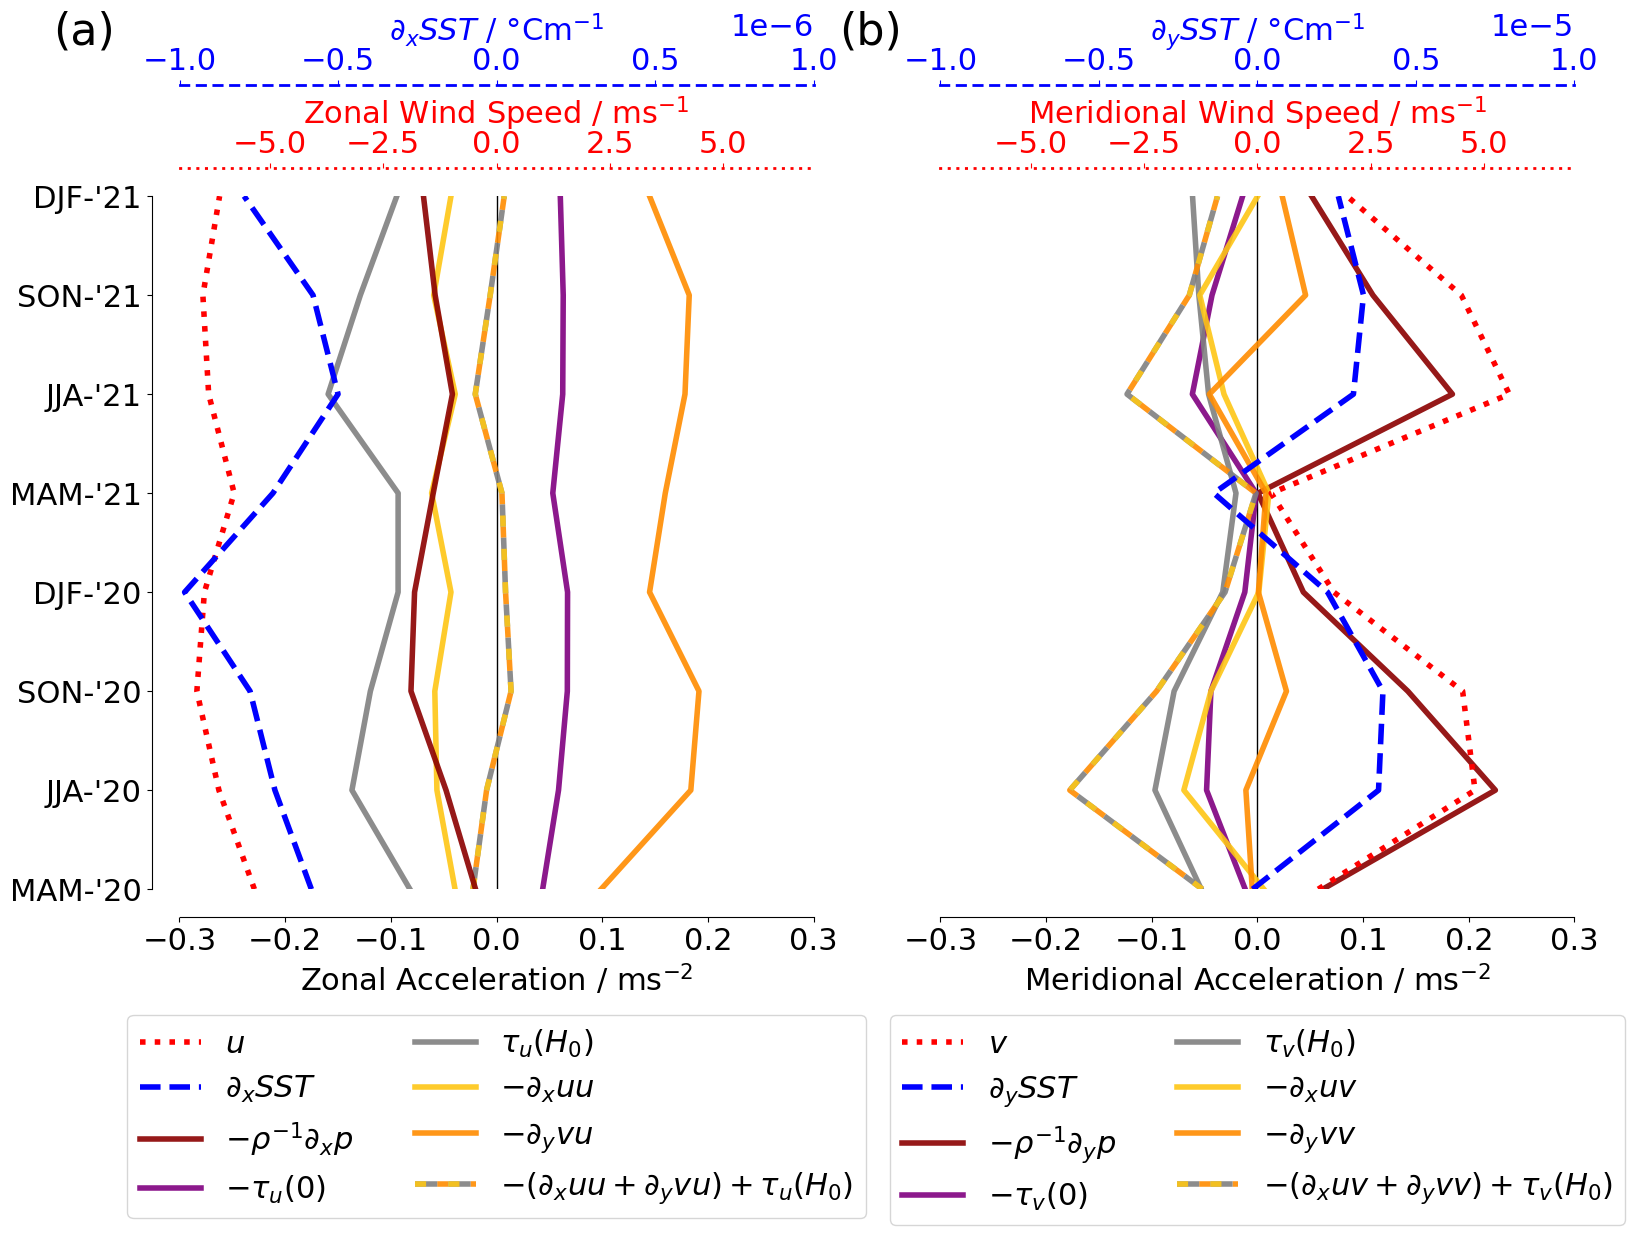

In [11]:
ALPHA = 0.9

fig = plt.figure(figsize=(18, 9), facecolor='w', edgecolor='k')
G = gridspec.GridSpec(1,2)

ax1 = plt.subplot(G[0,0])
ax11 = ax1.twiny()
ax111 = ax1.twiny()

ax1.axvline(0, color='black', ls='solid', lw=1)

#ax1.plot(list_zonal_tendency_spatial_mean, np.arange(len(list_year_season)), alpha=0.5, lw=LW, alpha=ALPHA, color="blue", label='Tendency')
#ax1.plot(list_zonal_Coriolis_force_spatial_mean, np.arange(len(list_year_season)), alpha=0.5, lw=LW, alpha=ALPHA, color="green", label='Coriolis Force')
prs, = ax1.plot(list_zonal_pressure_gradient_force_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="darkred", label=r'$\rho^{-1} \partial_x p$', zorder=10)
sfcdrag, = ax1.plot(list_zonal_surface_drag_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="purple", label=r'$\tau_u(0)$')
turbfl, = ax1.plot(list_zonal_vertical_turbulent_flux_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="grey", label=r'$\tau_u(H_0)$')

udxu, = ax1.plot(-list_zonal_duudx_force_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="#fec615", label=r'$-\partial_x uu$', zorder=5)
vdyu, = ax1.plot(-list_zonal_duvdy_force_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="#ff8c00", label=r'$-\partial_y vu$', zorder=5)
#ax1.plot(list_zonal_advection_force_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="orange", label=r'$-(u \partial_x u + v \partial_y u)$', zorder=10)

part1, = ax1.plot(list_zonal_zebra_line_spatial_mean, np.arange(len(list_year_season)), dashes=[4, 2], lw=LW, alpha=ALPHA, color="grey", gapcolor="#ff8c00", label=r'$-(\partial_x uu + \partial_y vu) + \tau_h$')
part2, = ax1.plot(list_zonal_zebra_line_spatial_mean, np.arange(len(list_year_season)), dashes=[2, 4], lw=LW, alpha=ALPHA, color="#fec615")

#ax1.plot(list_zonal_Psi, np.arange(len(list_year_season)), color="black", label=r'$\Psi$', ls='dotted')

ax1.set_xlim(-0.3,0.3)
ax1.spines[['top','right']].set_visible(False)
ax1.spines[['bottom', 'left']].set_position(('outward',20))
ax1.set_ylim(0,7)
ax1.set_yticklabels(["MAM-'20", "JJA-'20", "SON-'20", "DJF-'20", "MAM-'21", "JJA-'21", "SON-'21", "DJF-'21",''])
ax1.set_xlabel(r'Zonal Acceleration / $\mathrm{ms}^{-2}$', color='black')


uwind, = ax11.plot(list_zonal_wind_spatial_mean, np.arange(len(list_year_season)), color="red", lw=LW, label=r'Reference Wind', ls='dotted')

ax11.set_xlim(-7,7)
ax11.spines[['top']].set_visible(True)
ax11.spines[['left', 'bottom','right']].set_visible(False)
ax11.spines[['top']].set_position(('outward',20))
ax11.spines['top'].set_linestyle((0,(0.1,3)))
ax11.spines['top'].set_linewidth(2)
ax11.spines['top'].set_color('red')
ax11.yaxis.label.set_color('red')
ax11.tick_params(axis='x', colors='red')
ax11.set_xlabel(r'Zonal Wind Speed / $\mathrm{ms}^{-1}$', color='red')#, rotation=-90)

dxsst, = ax111.plot(list_dto_dx_gradient_force_spatial_mean, np.arange(len(list_year_season)), lw=LW, color="blue", label=r'SST Gradient', ls='dashed')

ax111.set_xlim(1*-10e-7,1*10e-7)
ax111.spines[['top']].set_visible(True)
ax111.spines[['left', 'bottom','right']].set_visible(False)
ax111.spines[['top']].set_position(('outward',80))
ax111.spines['top'].set_linestyle((0,(3,3)))
ax111.spines['top'].set_linewidth(2)
ax111.spines['top'].set_color('blue')
ax111.yaxis.label.set_color('blue')
ax111.tick_params(axis='x', colors='blue')
ax111.set_xlabel(r'$\partial_x SST$ / $\mathrm{°Cm}^{-1}$', color='blue')#, rotation=-90)

#ax1.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), fancybox=True, shadow=False, ncol=2)
ax1.legend([uwind, dxsst, prs, sfcdrag, turbfl, udxu, vdyu, (part1, part2)], [r'$u$', r'$\partial_x SST$', r'$-\rho^{-1} \partial_x p$', r'$-\tau_u(0)$', r'$\tau_u(H_0)$', r'$-\partial_x uu$', r'$-\partial_y vu$', r'$-(\partial_x uu + \partial_y vu) + \tau_u(H_0)$'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.16), fancybox=True, shadow=False, ncol=2)

ax2 = plt.subplot(G[0,1])
ax22 = ax2.twiny()
ax222 = ax2.twiny()

ax2.axvline(0, color='black', ls='solid', lw=1)

prs, = ax2.plot(list_merid_pressure_gradient_force_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="darkred", label=r'$\rho^{-1} \partial_y p$')
#ax2.plot(list_merid_tendency_spatial_mean, np.arange(len(list_year_season)), alpha=0.5, lw=LW, alpha=ALPHA, color="blue", label='Tendency')
#ax2.plot(list_merid_Coriolis_force_spatial_mean, np.arange(len(list_year_season)), alpha=0.5, lw=LW, alpha=ALPHA, color="green", label='Coriolis Force')
udxv, = ax2.plot(-list_merid_dvudx_force_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="#fec615", label=r'$-\partial_x uv$', zorder=5)
vdyv, = ax2.plot(-list_merid_dvvdy_force_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="#ff8c00", label=r'$-\partial_y vv$', zorder=5)
#ax2.plot(list_merid_advection_force_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="orange", label=r'$-(u \partial_x v + v \partial_y v)$', zorder=10)

sfcdrag, = ax2.plot(list_merid_surface_drag_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="purple", label=r'$\tau_v(0)$')
turbfl, = ax2.plot(list_merid_vertical_turbulent_flux_spatial_mean, np.arange(len(list_year_season)),  lw=LW, alpha=ALPHA, color="grey", label=r'$\tau_v(h)$')

part1, = ax2.plot(list_merid_zebra_line_spatial_mean, np.arange(len(list_year_season)), dashes=[4, 2], lw=LW, alpha=ALPHA, color="grey", gapcolor="#ff8c00", label=r'$-(\partial_x uv + \partial_y vv) + \tau_0$')
part2, = ax2.plot(list_merid_zebra_line_spatial_mean, np.arange(len(list_year_season)), dashes=[2, 4], lw=LW, alpha=ALPHA, color="#fec615")

ax2.plot(list_merid_Psi, np.arange(len(list_year_season)), color="black", label=r'$\Psi$', ls='dotted')

ax2.set_xlim(-0.3,0.3)
ax2.spines[['top','right','left']].set_visible(False)
ax2.spines[['bottom']].set_position(('outward',20))
ax2.set_ylim(0,7)
ax2.set_yticklabels([])
ax2.tick_params(axis='y', colors='white')
ax2.set_xlabel(r'Meridional Acceleration / $\mathrm{ms}^{-2}$', color='black')


vwind, = ax22.plot(list_merid_wind_spatial_mean, np.arange(len(list_year_season)), lw=LW, color="red", label=r'Reference Wind', ls='dotted')

ax22.set_xlim(-7,7)
ax22.spines[['top']].set_visible(True)
ax22.spines[['left', 'bottom','right']].set_visible(False)
ax22.spines[['top']].set_position(('outward',20))
ax22.spines['top'].set_linestyle((0,(0.1,3)))
ax22.spines['top'].set_linewidth(2)
ax22.spines['top'].set_color('red')
ax22.yaxis.label.set_color('red')
ax22.tick_params(axis='x', colors='red')
ax22.set_xlabel(r'Meridional Wind Speed / $\mathrm{ms}^{-1}$', color='red')#, rotation=-90)

dysst, = ax222.plot(list_dto_dy_gradient_force_spatial_mean, np.arange(len(list_year_season)), lw=LW, color="blue", label=r'Zonal SST Gradient', ls='dashed')

ax222.set_xlim(1*-10e-6,1*10e-6)
ax222.spines[['top']].set_visible(True)
ax222.spines[['left', 'bottom','right']].set_visible(False)
ax222.spines[['top']].set_position(('outward',80))
ax222.spines['top'].set_linestyle((0,(3,3)))
ax222.spines['top'].set_linewidth(2)
ax222.spines['top'].set_color('blue')
ax222.yaxis.label.set_color('blue')
ax222.tick_params(axis='x', colors='blue')
ax222.set_xlabel(r'$\partial_y SST$ / $\mathrm{°Cm}^{-1}$', color='blue')#, rotation=-90)

ax2.legend(loc='upper center', bbox_to_anchor=(0.5, -0.16), fancybox=True, shadow=False, ncol=2)
ax2.legend([vwind, dysst, prs, sfcdrag, turbfl, udxv, vdyv, (part1, part2)], [r'$v$', r'$\partial_y SST$', r'$-\rho^{-1} \partial_y p$', r'$-\tau_v(0)$', r'$\tau_v(H_0)$', r'$-\partial_x uv$', r'$-\partial_y vv$', r'$-(\partial_x uv + \partial_y vv) + \tau_v(H_0)$'], 
           loc='upper center', bbox_to_anchor=(0.5, -0.16), fancybox=True, shadow=False, ncol=2)

ax1.text(-0.2, 1.22, '(a)', fontsize=SIZE+10, transform=ax1.transAxes)
ax2.text(-0.16, 1.22, '(b)', fontsize=SIZE+10, transform=ax2.transAxes)

filename = f'fig_06_revised.pdf'
filepath = 'figs_review/'
plt.savefig(filepath + filename, facecolor='white', bbox_inches='tight', dpi=800)

plt.show()